In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer

from LoopStructural.modelling.fault.fault_function import CubicFunction, FaultDisplacement, Ones, Composite
from LoopStructural.modelling.fault.fault_function_feature import FaultDisplacementFeature

from LoopStructural.datasets import value_headers, strike_dip_headers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
output='graben'
if not os.path.exists(output):
    os.mkdir(output)

In [3]:
bb = np.array([[0,0,0],
               [20,10,10]])
fault_value_data1 = pd.DataFrame([[2,5,9,0,0],
                                 [5,5,5,0,1],
#                                  [7,7,7,1,1],
                                 [5,0,5,0,2],
                                 [5,10,5,1,2],
                                ],
                                columns=value_headers()+['coord'])
fault_value_data1['type'] = 'fault1'
fault_strike_data1 = pd.DataFrame([[5,5,5,0,60,0],
                                  [5,5,5,180,60,1],
                                 [5,5,5,90,90,2]],
                                columns=strike_dip_headers()+['coord'])
fault_strike_data1['type'] = 'fault1'

fault_value_data2 = pd.DataFrame([[10,5,9,0,0],
#                                   [19,2,2,1,0],
#                                   [17,5,9,-1,0],
                                 [5,5,5,0,1],
#                                  [7,7,7,1,1],
                                 [5,0,5,0,2],
                                 [5,10,5,1,2],
                                ],
                                columns=value_headers()+['coord'],)
fault_value_data2['type'] = 'fault2'
fault_strike_data2 = pd.DataFrame([[5,5,5,180,60,0,1],
                                  [5,5,5,0,60,1],
                                 [5,5,5,90,90,2]],
                                columns=strike_dip_headers()+['coord','polarity'])
fault_strike_data2['type'] = 'fault2'


strati_data = pd.DataFrame([[5,5,5,0]],columns=value_headers())
strati_data['type'] = 'strati'
strati_strike = pd.DataFrame([[5,5,5,0,0]],columns=strike_dip_headers())
strati_strike['type'] = 'strati'

In [4]:
data = pd.concat([fault_strike_data1,fault_value_data1,fault_strike_data2,fault_value_data2,strati_strike,strati_data],sort=False)

In [5]:
rotation = [76.60582733154297, -13.266486167907715, -176.5645294189453]

### Set up the model

In [15]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)


fault = model.create_and_add_fault('fault1',
                                   1,
                                   nelements=2000,
                                   interpolatortype='FDI',
                                   solver='lu',
                                   damp=True,
                                   buffer=0.3)
abutregion = lambda pos : fault['feature'].evaluate(pos)
fault2 = model.create_and_add_fault('fault2',
                                   1,
                                   nelements=2000,
                                   interpolatortype='FDI',
                                   solver='lu',
                                   damp=True,
                                   buffer=0.4,
                                    abut=fault['feature']
                                   )
# ## no intersection relationship between faults
# fault2['feature'][0].faults = [] 
# fault2['feature'][1].faults = [] 
# fault2['feature'][2].faults = [] 

# # ## add antithetic relationship to younger fault
# fault['feature'][0].add_region(lambda pos: fault2['feature'].evaluate(pos))
# fault['feature'][1].add_region(lambda pos: fault2['feature'].evaluate(pos))
# fault['feature'][2].add_region(lambda pos: fault2['feature'].evaluate(pos))

strati = model.create_and_add_foliation('strati',
                                        nelements=2000,
                                        interpolatortype='FDI',
                                        solver='lu',
                                        damp=True,buffer=0.5)
# f1_displacement_feature = FaultDisplacementFeature(fault['feature'].faultframe,fault_displacement)


### Fault surfaces

In [ ]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],isovalue=0, colour='red')
viewer.add_isosurface(fault2['feature'],isovalue=0,colour='black')
# hack to make the scale the same
viewer.add_section(None,axis='y',value=model.bounding_box[0,1],colour='white')
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# # viewer.add_isosurface(fault['feature'][1],nslices=5)
# # # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
# viewer.add_scalar_field(strati['feature'],cmap='tab20')
# # viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
# for k in presets:
#     viewer.lv[k]=presets[k]
viewer.lv['xmin'] = -1
viewer.lv['ymin'] = -1
viewer.lv['zmin'] = -1
viewer.lv['xmax'] = 1
viewer.lv['ymax'] = 1
viewer.lv['zmax'] = 1
# viewer.lv['bounds'] = {"max": [1.0, 0.5000356435775757, 0.5449897050857544], "min": [0.0, -3.891827509505674e-05, -4.440892098500626e-16]}
viewer.lv['border'] = 0
viewer.lv.display()
lines = viewer.lv.lines('outline') 

viewer.lv.image(output+'/faults.png')
# viewer.interactive()

### Active interpolation nodes

In [ ]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],
                      isovalue=0,
                     )
viewer.add_isosurface(fault2['feature'],
                      isovalue=0,
                      colour='black'
                     )

nodes = model.regular_grid()#fault2['feature'][0].get_interpolator().support.nodes
p1 = viewer.lv.points('nodes2',pointsize=6,colour='grey')
p1.vertices(nodes[np.logical_or(~fault['feature'].evaluate(nodes),
                                ~fault2['feature'].evaluate(nodes)),:])
nodes  = nodes[~np.logical_or(~fault['feature'].evaluate(nodes),
                                ~fault2['feature'].evaluate(nodes)),:]
p = viewer.lv.points('nodes',pointsize=6,colour='black')
p.vertices(nodes)
# nodes = fault1['feature'].apply_to_points(nodes)
# p = viewer.lv.points('nodes_faulted',pointsize=3,colour='blue')
# p.vertices(nodes)
# nodes = fault2['feature'].apply_to_points(nodes)
# p = viewer.lv.points('nodes_faulted2',pointsize=3,colour='blue')
# p.vertices(nodes)

# viewer.add_vector_field(fault1['feature'][1])#,model.regular_grid((25,25,12)))
viewer.lv.rotate(rotation)
viewer.lv['xmin'] = -1
viewer.lv['ymin'] = -1
viewer.lv['zmin'] = -1
viewer.lv['xmax'] = 1
viewer.lv['ymax'] = 1
viewer.lv['zmax'] = 1
viewer.lv['border'] = 0
viewer.lv.image(output+'/points_before_fault.png')
viewer.lv.display()

### Faulted nodes antithetic fault

In [ ]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],
                      isovalue=0,
                     )
viewer.add_isosurface(fault2['feature'],
                      isovalue=0,
                      colour='black'
                     )
fault2['feature'].faults = []
fault['feature'].faults = []

nodes = model.regular_grid()#fault2['feature'][0].get_interpolator().support.nodes
p1 = viewer.lv.points('nodes2',pointsize=6,colour='grey')
p1.vertices(nodes[~fault['feature'].evaluate(nodes),:])
nodes  = nodes[fault['feature'].evaluate(nodes),:]
p = viewer.lv.points('nodes',pointsize=6,colour='black')
# p.vertices(nodes)
nodes = fault['feature'].apply_to_points(nodes)
# # p = viewer.lv.points('nodes_faulted',pointsize=3,colour='blue')
p.vertices(nodes)
# nodes = fault['feature'].apply_to_points(nodes)
# # nodes = fault2['feature'].apply_to_points(nodes)
# # p = viewer.lv.points('nodes_faulted2',pointsize=3,colour='blue')
# # p.vertices(nodes)
# nodes = fault2['feature'].apply_to_points(nodes)
# p = viewer.lv.points('nodes_faulted3',pointsize=6,colour='black')
# p.vertices(nodes[~fault2['feature'].evaluate(nodes),:])
# p = viewer.lv.points('nodes_faulted4',pointsize=6,colour='grey')
# p.vertices(nodes[fault2['feature'].evaluate(nodes),:])
# nodes = model.regular_grid()
# nodes  = nodes[fault2['feature'].evaluate(nodes),:]
# p1 = viewer.lv.points('nodes3',pointsize=6,colour='red')
# p1.vertices(nodes)
# viewer.add_vector_field(fault2['feature'][1],locations=nodes)#,model.regular_grid((25,25,12)))

# viewer.add_vector_field(fault1['feature'][1])#,model.regular_grid((25,25,12)))
viewer.lv.rotate(rotation)
viewer.lv['xmin'] = -1
viewer.lv['ymin'] = -1
viewer.lv['zmin'] = -1
viewer.lv['xmax'] = 1
viewer.lv['ymax'] = 1
viewer.lv['zmax'] = 1
viewer.lv['border'] = 0
viewer.lv.image(output+'/main_fault_points.png')
viewer.lv.display()
# viewer.interactive()

### both faults points


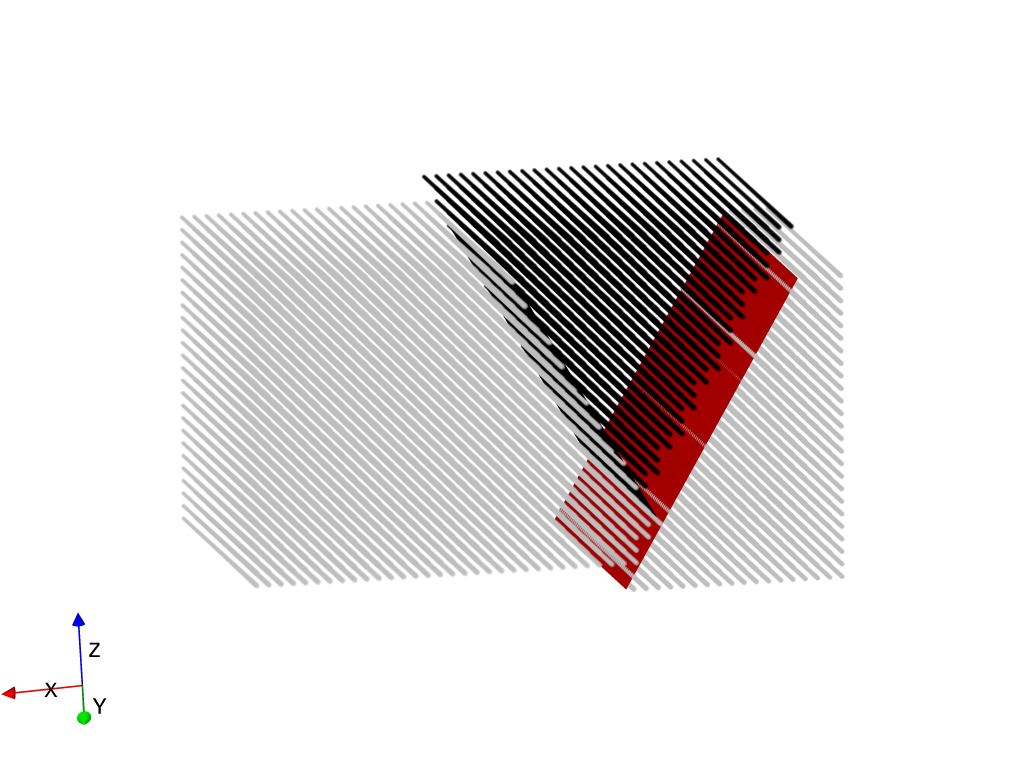

In [19]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],
                      isovalue=0,
                     )
viewer.add_isosurface(fault2['feature'],
                      isovalue=0
                      ,colour='black'
                     )
fault2['feature'].faults = []
fault['feature'].faults = []

nodes = model.regular_grid()#fault2['feature'][0].get_interpolator().support.nodes
p1 = viewer.lv.points('nodes2',pointsize=6,colour='grey')
p1.vertices(nodes[~fault['feature'].evaluate(nodes),:])
nodes  = nodes[fault['feature'].evaluate(nodes),:]
p = viewer.lv.points('nodes',pointsize=6,colour='black')
# p.vertices(nodes)
nodes = model.regular_grid()#fault2['feature'][0].get_interpolator().support.nodes
nodes = fault['feature'].apply_to_points(nodes)
# # p = viewer.lv.points('nodes_faulted',pointsize=3,colour='blue')
# p.vertices(nodes)
# nodes = fault['feature'].apply_to_points(nodes)
# # nodes = fault2['feature'].apply_to_points(nodes)
# # p = viewer.lv.points('nodes_faulted2',pointsize=3,colour='blue')
# # p.vertices(nodes)
nodes = fault2['feature'].apply_to_points(nodes)
# p = viewer.lv.points('nodes_faulted3',pointsize=6,colour='black')
p.vertices(nodes[fault2['feature'].evaluate(nodes),:])
p1 = viewer.lv.points('nodes3',pointsize=6,colour='grey')
# p1.vertices(nodes[np.logical_and(~fault2['feature'].evaluate(nodes),
#                                  fault['feature'].evaluate(nodes)),:])
p1.vertices(nodes[~fault2['feature'].evaluate(nodes),:])

# p = viewer.lv.points('nodes_faulted4',pointsize=6,colour='grey')
# p.vertices(nodes[fault2['feature'].evaluate(nodes),:])
# nodes = model.regular_grid()
# nodes  = nodes[fault2['feature'].evaluate(nodes),:]
# p1 = viewer.lv.points('nodes3',pointsize=6,colour='red')
# p1.vertices(nodes)
# viewer.add_vector_field(fault2['feature'][1],locations=nodes)#,model.regular_grid((25,25,12)))

# viewer.add_vector_field(fault1['feature'][1])#,model.regular_grid((25,25,12)))
viewer.lv.rotate(rotation)
viewer.lv['xmin'] = -1
viewer.lv['ymin'] = -1
viewer.lv['zmin'] = -1
viewer.lv['xmax'] = 1
viewer.lv['ymax'] = 1
viewer.lv['zmax'] = 1
viewer.lv['border'] = 0
viewer.lv.image(output+'/both_fault_points.png')
viewer.lv.display()
# viewer.interactive()

### Faulted stratigraphy figure


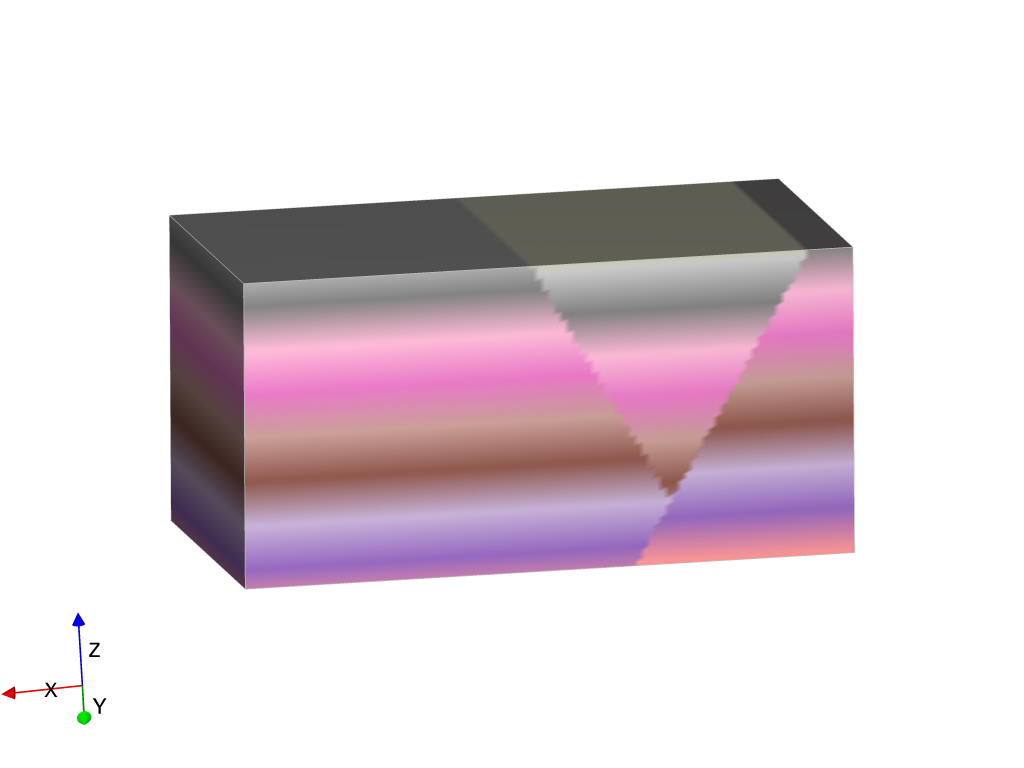

'graben/scalar_field.png'

In [17]:
viewer = LavaVuModelViewer(model)
viewer.nsteps = np.array([100,20,80])
viewer.add_scalar_field(strati['feature'],cmap='tab20')

# f1_displacement_feature = FaultDisplacementFeature(fault['feature'].faultframe,fault_displacement)
# viewer.add_scalar_field(f1_displacement_feature,cmap='viridis',vmin=-1,xmax=1)
# viewer.lv.rotatey(90)
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image(output+'/scalar_field.png')

### Surfaces

In [ ]:
# fregion = lambda pos : f1_displacement_feature.evaluate_on_surface(pos) > 0.2
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],
                      isovalue=0,
#                      region=fregion
                     )
viewer.add_isosurface(fault2['feature'],
                      isovalue=0,
                      colour='black'
#                      region=fregion
                     )
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
viewer.add_isosurface(strati['feature'],
#                       slices=[4,3,2,1],
                     nslices=10,
                     paint_with=strati['feature'],
                      cmap='tab20'
                     )
# strati['feature'].faults = []
viewer.add_isosurface(strati['feature'],
#                       slices=[4,3,2,1],
#                      nslices=0,
                     paint_with=strati['feature'],
                      cmap='tab20',
                      name = 'test'
                     )
# viewer.add_scalar_field(strati['feature'],cmap='tab20')
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image(output+'/surfaces.png')
# viewer.interactive()

### Final figure

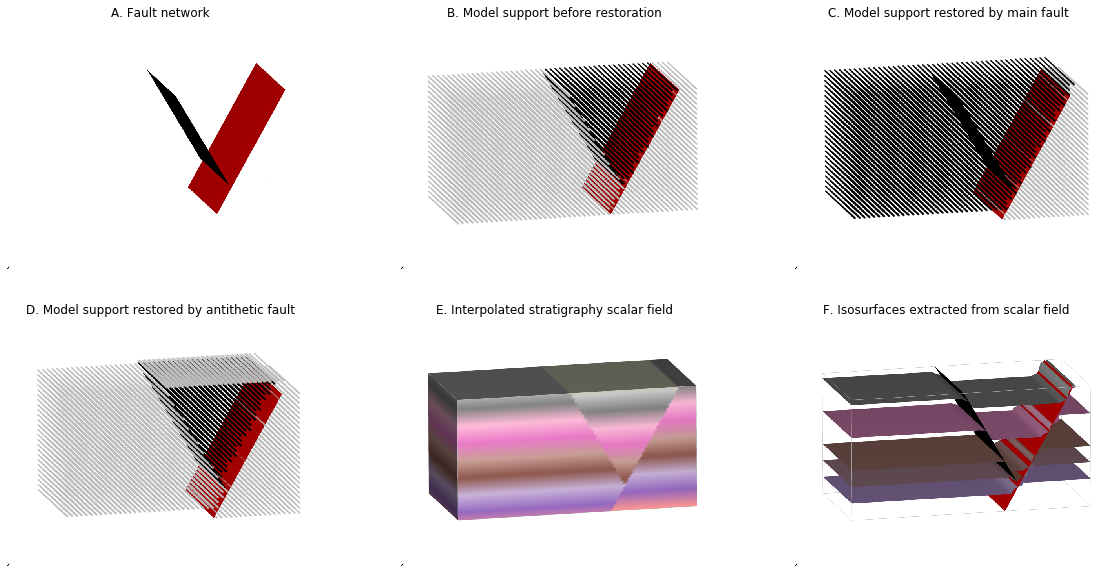

In [18]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0][0].imshow(plt.imread(output+'/faults.png')[75:705, 100:880,:])
ax[0][0].set_title('A. Fault network')
ax[0][1].imshow(plt.imread(output+'/points_before_fault.png')[75:705, 100:880,:])
ax[0][1].set_title('B. Model support before restoration')
ax[0][2].imshow(plt.imread(output+'/main_fault_points.png')[75:705, 100:880,:])
ax[0][2].set_title('C. Model support restored by main fault')
ax[1][0].imshow(plt.imread(output+'/both_fault_points.png')[75:705, 100:880,:])
ax[1][0].set_title('D. Model support restored by antithetic fault')
ax[1][1].imshow(plt.imread(output+'/scalar_field.png')[75:705, 100:880,:])
ax[1][1].set_title('E. Interpolated stratigraphy scalar field')
ax[1][2].imshow(plt.imread(output+'/surfaces.png')[75:705, 100:880,:])
ax[1][2].set_title('F. Isosurfaces extracted from scalar field ')
for i in range(2):
    for j in range(3):
        ax[i,j].axis('off')